# 基于 Attention 的 seq2seq 模型实现

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

步骤：
1. preprocessing data
2. build model
   1. encoder
   2. attention
   3. decoder
   4. loss & optimizer
   5. train
3. evaluation
   1. given sentence, return translated results
   2. visualize results (attention)

## 数据处理
### 数据预处理

In [3]:
en_spa_file_path = './data/data_spa_en/spa.txt'

# 将unicod编码转化为ascii，如果有多个ascii组成，则拆分，去掉重音
import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# test
en_sentence = 'Then what?'
sp_sentence = '¿Entonces qué?'

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Then what?
¿Entonces que?


In [4]:
# 西方语言常用：标点符号和字母分开
import re
def preprocess_sentence(s):
    # 转化成ascii，变小写去空格
    s = unicode_to_ascii(s.lower().strip())
    
    # 标点符号前后加空格
    s = re.sub(r'([?.!,¿])', r' \1 ', s)
    # 多余的空格变成一个空格
    s = re.sub(r'[" "]+', ' ', s)
    # 除了标点符号和字母外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]', ' ', s)
    # 去掉前后空格
    s = s.rstrip().strip()
    # 前后加标记
    s = '<start> ' + s + ' <end>'
    return s

# test
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> then what ? <end>
<start> ¿ entonces que ? <end>


In [5]:
# 解包和zip联用举例
a = [(1, 2), (3, 4), (5, 6)]
c, d = zip(*a)
print(c, d)

(1, 3, 5) (2, 4, 6)


In [6]:
# 解析文件
def parse_data(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocess_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs]
    # 解包和zip联用：将每一个元组解开，重新组合成两个新的列表
    return zip(*preprocess_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


### 数据id化

In [7]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='', split=' ')
    # 统计词频，生成词表
    lang_tokenizer.fit_on_texts(lang)
    # id化
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # padding
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [8]:
# 训练集和验证集切分
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(
    input_tensor, output_tensor, test_size = 0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [9]:
# 验证tokenizer是否转化正确
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))
            
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
80 --> voy
10 --> a
9235 --> regar
9 --> el
1807 --> jardin
3 --> .
2 --> <end>

1 --> <start>
4 --> i
38 --> ll
269 --> water
13 --> the
1441 --> garden
3 --> .
2 --> <end>


### 生成Dataset

In [10]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [11]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1   17   12 ...    0    0    0]
 [   1   25  174 ...    0    0    0]
 [   1    5 6675 ...    0    0    0]
 ...
 [   1   24 1190 ...    0    0    0]
 [   1   80   10 ...    0    0    0]
 [   1    9   44 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    4   29  106   21  643    3    2    0    0    0]
 [   1    4  129  408    3    2    0    0    0    0    0]
 [   1   40    5  249   10   83    6    2    0    0    0]
 [   1    4   16   34  674    3    2    0    0    0    0]
 [   1   92    4  178   10   23    6    2    0    0    0]
 [   1    4  438    9   70   15    5    3    2    0    0]
 [   1    7    8 1633 1855    3    2    0    0    0    0]
 [   1   13  480    8  818    3    2    0    0    0    0]
 [   1  459   13 2141    3    2    0    0    0    0    0]
 [   1    4 1327    5    3    2    0    0    0    0    0]
 [   1   29    5  355   20    6    2    0    0    0    0]
 [   1    7   26 1335    3    2    0    0    0    0    0]
 [   1

## 模型定义

In [12]:
# 定义超参数
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
batch_size = 64

### Encoder构建

In [13]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units, return_sequences=True,
                                    return_state=True, recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

In [14]:
# test
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)
print(sample_output.shape)
print(sample_hidden.shape)

(64, 16, 1024)
(64, 1024)


### Attention 构建 

In [15]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        # 维度不同，需要扩维
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        
        # before V: (batch_size, length, units)
        # after V: (batch_size, length, 1)
        # 计算score
        score = self.V(tf.nn.tanh(
            self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # attention_weights.shape: (batch_size, length, 1)
        # 得到权重
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector.shape: (batch_size, length, 1)
        # 加权求和
        context_vector = attention_weights * encoder_outputs
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [16]:
# test
attention_model = BahdanauAttention(units=10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)
print(attention_results.shape)
print(attention_weights.shape)

(64, 1024)
(64, 16, 1)


### Decoder构建

In [17]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units, return_sequences=True,
                                    return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        # 计算attention权重
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        # 先将attention 权重扩维，再与x连起来
        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        # output.shape: (batch_size, 1, decoding_units)
        # state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        
        # output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights

In [18]:
# test
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
decoder_output, decoder_hidden, decoder_aw = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_aw.shape)

(64, 4834)
(64, 1024)
(64, 16, 1)


### 损失函数和单步训练函数

In [19]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 计算单步损失函数
def loss_function(real, pred):
    # 计算所有非padding部分
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    # mask类型转化，与loss_保持一致
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [20]:
# 定义单步训练函数
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        decoding_hidden = encoding_hidden
        
        # eg:对于输入长度为5的序列，输出需要4步
        # 计算多步损失函数
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            predictions, decoding_hidden, _ = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions)
            
    batch_loss = loss / int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [21]:
checkpoint_dir = os.path.join('seq2seq_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### 模型训练

In [22]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

# 训练
for epoch in range(epochs):
    start = time.time()
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        # 计算总loss，打印日志
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    
    # 每5个周期（epoch）,保存（检查点）一次模型
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7767
Epoch 1 Batch 100 Loss 0.3567
Epoch 1 Batch 200 Loss 0.3398
Epoch 1 Batch 300 Loss 0.2930
Epoch 1 Batch 400 Loss 0.2768
Epoch 1 Loss 0.3322
Time take for 1 epoch 235.82640504837036 sec

Epoch 2 Batch 0 Loss 0.2580
Epoch 2 Batch 100 Loss 0.2535
Epoch 2 Batch 200 Loss 0.2428
Epoch 2 Batch 300 Loss 0.2180
Epoch 2 Batch 400 Loss 0.1898
Epoch 2 Loss 0.2214
Time take for 1 epoch 218.2403221130371 sec

Epoch 3 Batch 0 Loss 0.1776
Epoch 3 Batch 100 Loss 0.1736
Epoch 3 Batch 200 Loss 0.1663
Epoch 3 Batch 300 Loss 0.1392
Epoch 3 Batch 400 Loss 0.1116
Epoch 3 Loss 0.1452
Time take for 1 epoch 216.85228729248047 sec

Epoch 4 Batch 0 Loss 0.1171
Epoch 4 Batch 100 Loss 0.1086
Epoch 4 Batch 200 Loss 0.1004
Epoch 4 Batch 300 Loss 0.0907
Epoch 4 Batch 400 Loss 0.0655
Epoch 4 Loss 0.0917
Time take for 1 epoch 216.78517651557922 sec

Epoch 5 Batch 0 Loss 0.0665
Epoch 5 Batch 100 Loss 0.0633
Epoch 5 Batch 200 Loss 0.0618
Epoch 5 Batch 300 Loss 0.0756
Epoch 5 Batch 400 Loss 0.03

## 验证
### 给句子，返回翻译结果

In [23]:
def evaluate(input_sentence):
    # 定义attention矩阵
    attention_matrix = np.zeros((max_length_output, max_length_input))
    # 预处理
    input_sentence = preprocess_sentence(input_sentence)
    # text到id转化
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    # padding
    inputs = keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen = max_length_input, padding = 'post')
    # 转化为tensor
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
    # encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg:<start> -> A -> B -> ...
    # decoding_input.shape: (1, 1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
        
        # attention_weights.shape: (batch_size, length, 1) (1, 16, 1)
        # 缩维：(16)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size) (1, 4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # 保存翻译结果
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

### 可视化权重

In [24]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    # 展示矩阵不同颜色
    ax.matshow(attention_matrix, cmap = 'viridis')
    
    # 设置x轴和y轴
    font_dict = {'fontsize' : 14}
    ax.set_xticklabels([''] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = font_dict)
    plt.show()

### 翻译

In [25]:
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

In [26]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
print(tf.train.latest_checkpoint(checkpoint_dir))
# latest_path = os.path.join(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

seq2seq_checkpoints\ckpt-2


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold out . <end> 


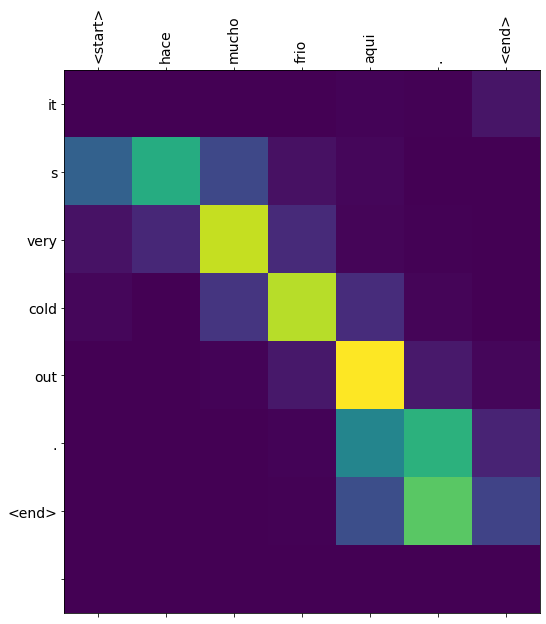

In [27]:
translate(u'Hace mucho frío aquí.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


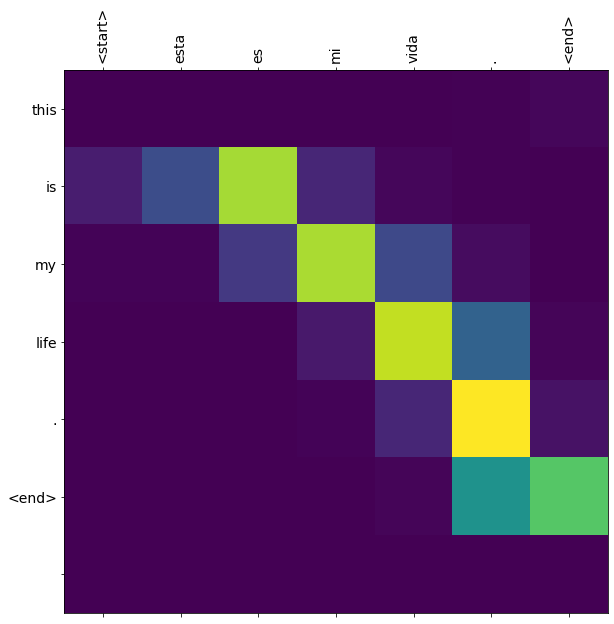

In [28]:
translate(u'Esta es mi vida.')

Input: <start> sigues en casa ? <end>
Predicted translation: i still at home . <end> 


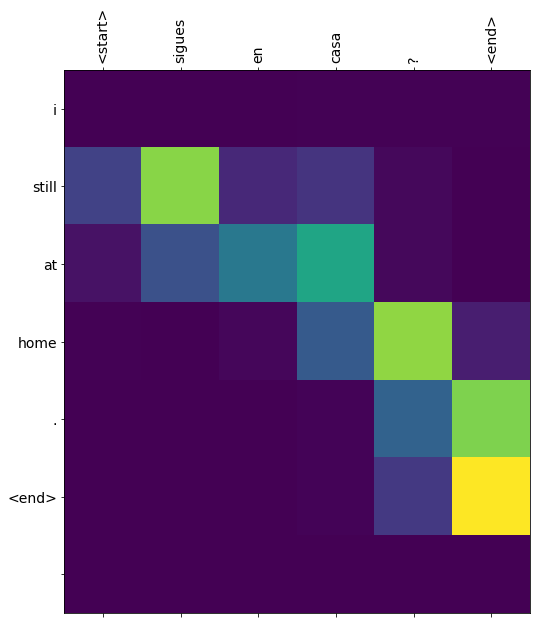

In [29]:
translate(u'sigues en casa ?')